# Домашняя работа по теме «Модели ARMA»

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

In [24]:
series = pd.read_csv("mean-monthly-air-temperature-deg.csv")['Deg']

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


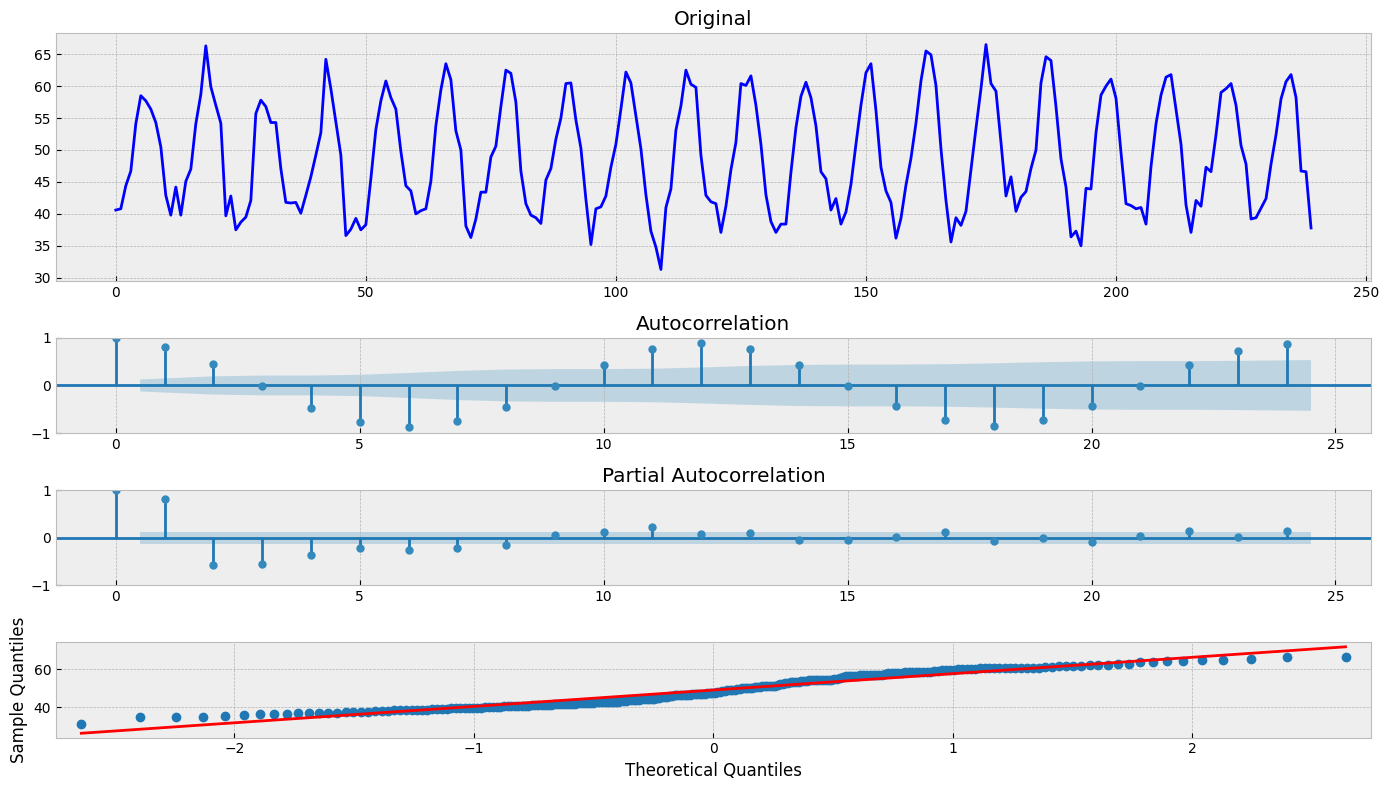

In [25]:
tsplot(series)

In [28]:
import warnings
warnings.filterwarnings("ignore")

In [26]:
best_aic = np.inf
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i, d, j)).fit(method='innovations_mle')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except Exception as e:
                print(f"Error fitting ARIMA({i},{d},{j}): {e}")
                continue

if best_order is not None:
    print('Best order: {}'.format(best_order))
    print('AIC: {:6.5f}'.format(best_aic))
else:
    print('No suitable ARIMA model found.')

Best order: (3, 0, 2)
AIC: 1136.11305


Results of Dickey-Fuller Test:
Test Statistic                  -5.623924
p-value                          0.000001
#Lags Used                       5.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64


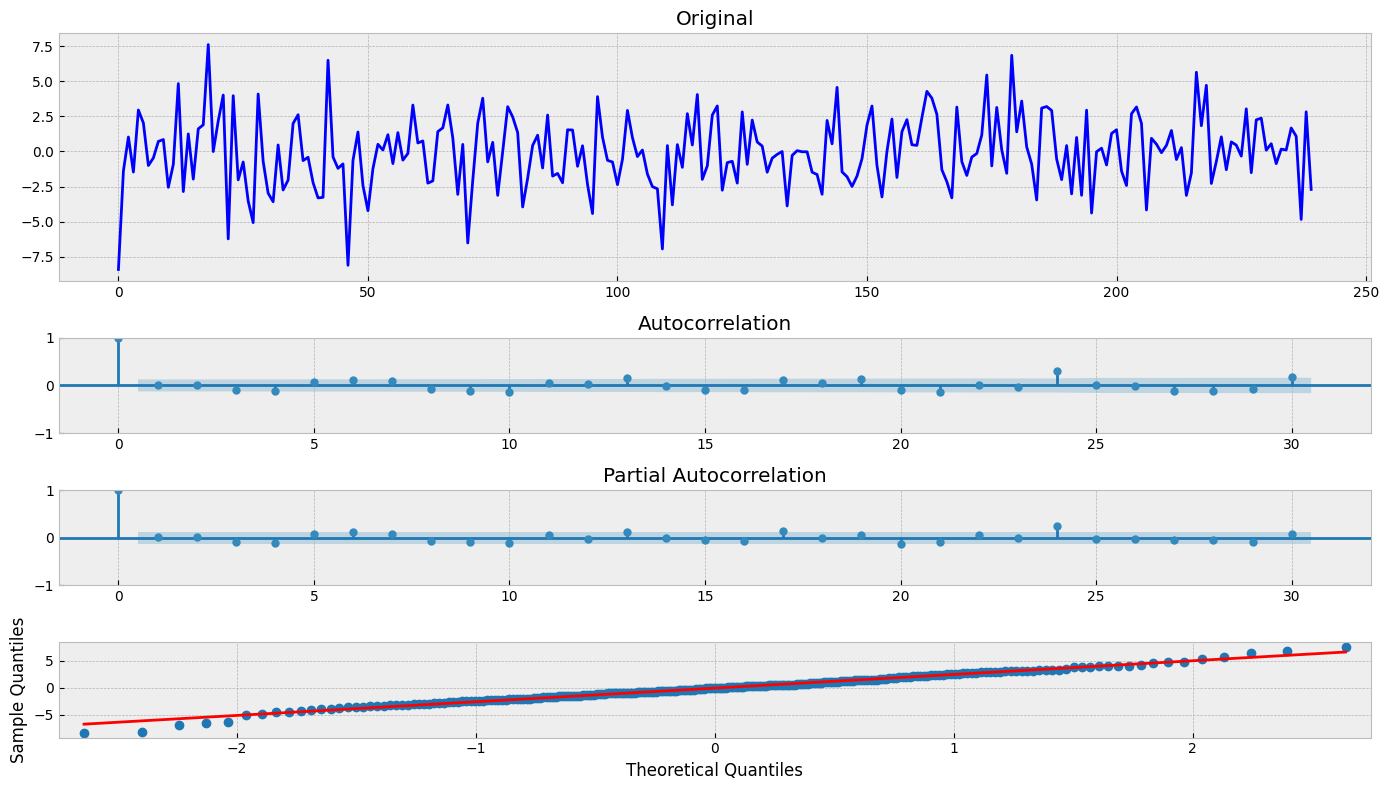

In [27]:
tsplot(best_mdl.resid, lags=30)

Ряд остатков стационарен, значит модель подходит для описания данных

In [29]:
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

In [33]:
model = smt.ARIMA(train, order=(3, 0, 2))
model = model.fit(method='innovations_mle')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Count   No. Observations:                   94
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -459.110
Date:                Fri, 09 Aug 2024   AIC                            932.221
Time:                        20:17:12   BIC                            950.024
Sample:                             0   HQIC                           939.412
                                 - 94                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        177.7912    115.309      1.542      0.123     -48.211     403.793
ar.L1          0.4533      0.297      1.528      0.127      -0.128       1.035
ar.L2          0.5280      0.363      1.454      0.146      -0.184       1.240
ar.L3          0.0081      0.230      0.035      0.972      -0.442       0.458
ma.L1          0.1790      0.280      0.640      0.522      -0.370       0.728
ma.L2         -0.4425      0.239     -1.850      0.064      -0.911       0.026
sigma2       988.5999    101.584      9.732      0.000     789.498    1187.702
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                28.31
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):              10.78   Skew:                             0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
pred = model.predict()
print(pred)

0     177.791199
1      45.936243
2      43.262199
3      49.333028
4      42.423825
         ...    
89    293.624608
90    267.035668
91    305.556252
92    347.576767
93    307.033015
Name: predicted_mean, Length: 94, dtype: float64


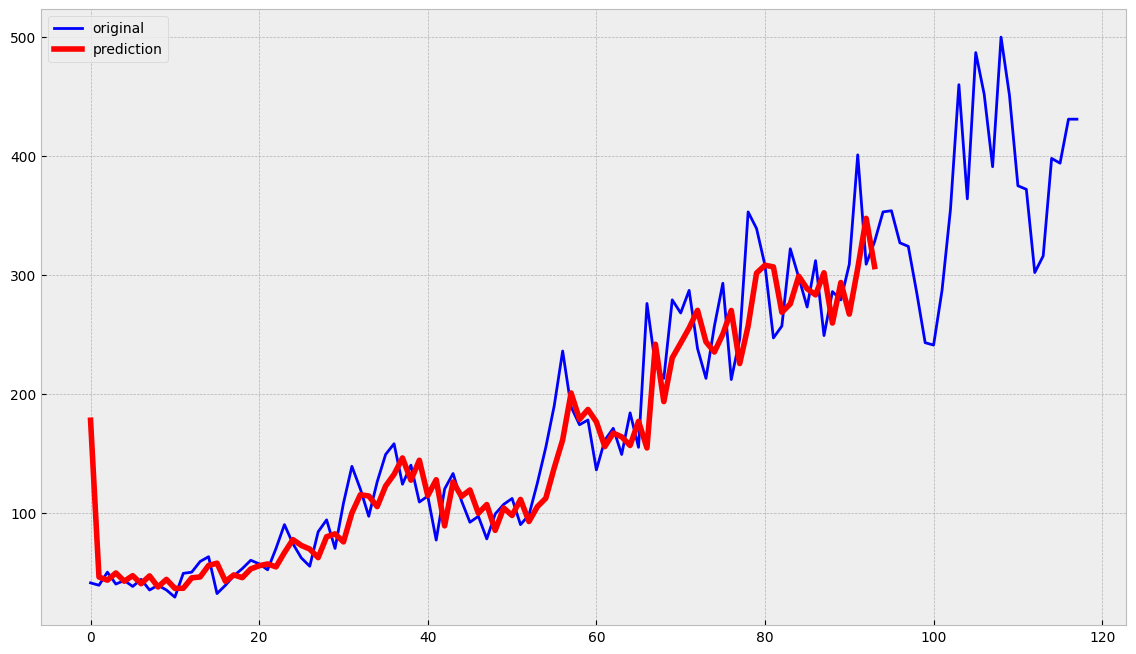

In [36]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(pred, color='red', linewidth='4', label='prediction')
    plt.legend()